<a href="https://colab.research.google.com/github/adbemper-netizen/data-mining-home-work/blob/main/%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E3%83%AA%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 演習
気象データをもとに，都道府県のグループをクラスタとしてクラスタリングにより抽出する以降の処理において，以下の関数を完成させてください。
- 関数`squared_euclid_dist`
- 関数`k_means`


### 準備

In [ ]:
!pip install matplotlib-fontja

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_fontja

政府統計ポータルサイト[e-Stat](https://www.e-stat.go.jp/regional-statistics/ssdsview)では，「統計でみる都道府県・市区町村のすがた（社会・人口統計体系）」で整備された各種統計データから，地域・項目を抽出してデータをダウンロードすることができます．

ここでは，「自然環境」分野の「気象条件」分類から各都道府県の2020年度の「年平均気温 ($\circ \mathrm{C}$)」と「年間降水量 (mm)」に関する気象データを，CSVファイルとして取得しました．

以下では，取得したCSVファイルをもとに次に示すようなデータフレームを作成しています．



In [ ]:
!wget https://raw.githubusercontent.com/PythonDSBook/notebooks/main/data/weather.csv

In [ ]:
df = pd.read_csv('weather.csv') # CSVファイルを読み込みデータフレームを作成

In [ ]:
df.head()

,地域,年平均気温,年間降水量
0,北海道,10.0,905.0
1,青森県,11.6,1417.0
2,岩手県,11.4,1462.0
3,宮城県,13.7,1247.0
4,秋田県,12.8,2022.5


データフレームは47都道府県の「年平均気温」と「年間降水量」の列からなります．
以下では，都道府県のこの気象データをもとに，「年平均気温」と「年間降水量」の特徴が類似した都道府県のグループをクラスタとしてクラスタリングにより抽出することを考えます．

### 階層化クラスタリング
[SciPy](https://scipy.org/)ライブラリはさまざまな数値解析の機能を提供するライブラリであり，NumPyライブラリの上に構築されています．

SciPyに含まれているclusterパッケージの[hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html)モジュールでは，階層化クラスタリングを行うための機能が提供されています．

以下では，先の都道府県の気象データのデータフレームから各都道府県を行，「年平均気温」と「年間降水量」の特徴を列とする$47 \times 2$のサイズの行列を表す2次元配列`X`を作成し，都道府県のクラスタリングを行います．

まず，データセットの事例の特徴である「年平均気温」と「年間降水量」は異なる範囲の値をとるため，各特徴の平均値が0，分散が1となるように標準化を行います．

具体的には，配列の[`mean`](https://numpy.org/doc/2.1/reference/generated/numpy.mean.html)メソッドと[`std`](https://numpy.org/doc/2.1/reference/generated/numpy.std.html)を用いて次のように2次元配列`X`の列ごとに平均値と標準偏差の値を計算した上で，列ごとに標準化を行います．

このとき，NumPyのブロードキャスト機能により，各列の平均値を要素とする配列`X.mean(axis=0)`と標準偏差を要素とする配列`X.std(axis=0)`の行数は，それぞれ`X`の行数と同じになるように揃えられた上で計算が行われます．
- 引数`axis`に0を指定すると，配列の列ごとに処理した結果を配列として返します．

In [ ]:
# 特徴の標準化
X = df[['年平均気温', '年間降水量']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)

以下では，hierarchyモジュールの関数[`linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)に`X`を与えて，階層化クラスタリングを行っています．

また，同モジュールの関数[`dendrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)を用いて，クラスタリング結果をデンドログラムとして可視化しています．

- 関数`linkage`は，データセットとなる[事例の数] × [特徴の数]のサイズの行列を表す2次元配列が与えられ，引数`metric`に指定した事例間の距離尺度，引数`method`に指定したクラスタの併合方法をもとに階層化クラスタリングを行い，クラスタの併合過程の情報を表す配列を返します．
  - ここでは，事例間の距離尺度としてユークリッド距離（`euclidean`）を用います．
  - クラスタ間の距離尺度の最短距離法，最長距離法，群平均法に対応してそれぞれクラスタの併合方法として単連結（`single`），完全連結（`complete`），平均連結（`average`）を指定します．
  - ここでは，クラスタの併合方法として平均連結（`average`）を用います．
- 関数`dendrogram`は，関数`linkage`の返り値の配列が与えられ，それをデンドログラムとして可視化します．
  - デンドログラムの各葉はデータセットの各事例に対応しています．
  - 引数`labels`には，デンドログラムの葉のラベルを要素としたシーケンスオブジェクト（リストや配列のように整数値のインデックスを指定して要素を参照できるオブジェクト）を指定できます．
  - 引数`color_threshold`に指定したしきい値より短いクラスタ間距離で併合したクラスタを色分けすることができます．
  - ここでは，クラスタ間の距離のしきい値として`1.8`を指定して4つのクラスタを抽出して色分けしています．

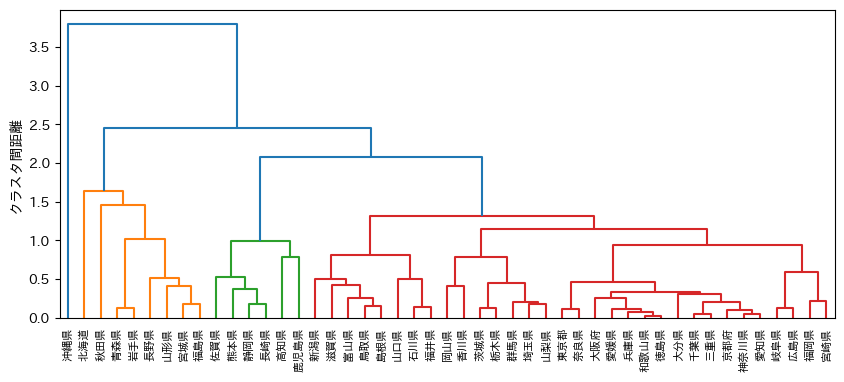

In [ ]:
# 階層化クラスタリングの実行
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 4))

clusters = linkage(X, metric='euclidean', method='average')
dendrogram(clusters, labels=df['地域'].values, color_threshold=1.8)
plt.ylabel('クラスタ間距離')
plt.show()

### K-means法によるクラスタリング
以下では，K-means法によるクラスタリングを行うためのプログラムを作成します．
まず準備として，ベクトル間の距離を計算する関数を作成します．

以下の関数`squared_euclid_dist`は，引数`vec1`と`vec2`にベクトルを表す1次元配列がそれぞれ与えられ，それらのベクトル間の平方ユークリッド距離を返り値として返します．

In [ ]:
# 平方ユークリッド距離の計算
def squared_euclid_dist(vec1, vec2):
  return ... # 1次元配列で表された2つのベクトルの対応する要素の差の二乗和を計算

以下のセルを実行して動作を確認してください．

In [ ]:
assert squared_euclid_dist(np.array([-1, -2]), np.array([1, 2])) == 20
assert np.isclose(squared_euclid_dist(np.array([1.5, 2.5]), np.array([0.5, 1.5])), 2.0)

続いて，以下の仕様の関数`k_means`を定義します．

 引数 | 説明
 --- | ---
`X`| データセットの[事例の数]$\times$[特徴の数]のサイズの行列を表す2次元配列
`k`| クラスタ数$k$

 返り値 | 説明
 --- | ---
`clusters` | 各事例に割り当てられたクラスタのラベル（$0$から$k-1$の間の整数値）を要素とする1次元配列
`centroids` | [クラスタの数] $×$ [特徴の数]のサイズの行列（各行が各クラスタのセントロイドに対応）を表す2次元配列
`cost` | 最終的な損失関数の値

引数`max_iterations`にはセントロイド割り当てと更新の繰り返しの回数，引数`random_seed`には初期のセントロイドをランダムに選択する際の擬似乱数の種（シード）となる値を，それぞれ指定することができます．
  - ここでは，デフォルトの値として，それぞれ`10`と`0`を指定しています．関数が呼び出された際，これらの引数が省略された場合はデフォルトの値が引数の値となります．

In [ ]:
def k_means(X, k, max_iterations=10, random_seed=0):
  np.random.seed(random_seed)
  m = X.shape[0]
  centroids = X[np.random.choice(m, k, replace=False)]
  clusters = np.zeros(m)
  dist_matrix = np.zeros((m, k))

  for iteration in range(max_iterations):

    for i in range(m):
      for j in range(k):
        dist_matrix[i, j] = ... # 事例iとクラスタjのセントロイドの平方ユークリッド距離
    clusters = np.argmin(dist_matrix, axis=1)

    for j in range(k):
      centroids[j] = ... # クラスタjのセントロイドを更新

  cost = ... # 損失関数の値の計算

  return clusters, centroids, cost

以下のセルを実行して動作を確認してください．

In [ ]:
k = 2
clusters, centroids, cost = k_means(X, k, max_iterations=10, random_seed=0)
assert len(set(clusters)) == k
assert centroids.shape == (k, X.shape[1])
assert np.allclose(centroids[0], [-0.338, -0.611], rtol=1e-2, atol=1e-2)
assert np.allclose(centroids[1], [0.597, 1.079], rtol=1e-2, atol=1e-2)
assert np.round(cost, 2) == 53.48

以下では，関数`k_means`に先の都道府県の気象データを表す2次元配列`X`を与えて呼び出すことでK-means法によるクラスタリングを実行し，その返り値を変数`clusters`, `centroids`, `cost`にそれぞれ代入しています．
ここではクラスタ数として4を指定しています．

In [ ]:
# K-means法によるクラスタリングの実行
k = 4
clusters, centroids, cost = k_means(X, k)

実行の結果，`clusters`は次のように各事例に割り当てられたクラスタのラベルを要素とする1次元配列となっています．

要素の順番は`X`の行の順番と対応しており，たとえば，`X`の先頭行に対応する事例にはラベル`3`のクラスタが，終端行に対応する事例にはラベル`1`のクラスタが割り当てられていることがわかります．

In [ ]:
print(clusters) # 各事例に割り当てられたクラスタのラベル

[3 3 3 3 3 3 3 0 0 0 0 0 0 0 2 2 2 2 0 3 2 1 0 0 2 0 0 0 0 0 2 2 0 2 2 0 0
 0 1 1 1 1 1 0 1 1 1]


クラスタリングの結果，最終的に得られた各クラスタに対応するセントロイドは2次元配列`centroids`の各行により確認することができます

In [ ]:
print(np.round(centroids, 2)) # セントロイド

[[ 0.24 -0.56]
 [ 1.09  1.48]
 [-0.12  0.58]
 [-1.68 -0.98]]


以下では，クラスタリングの結果を次に示すような散布図として可視化しています．
各都道府県をクラスタごとに色分けし，各クラスタのセントロイドを$\times$印で表しています．
- 各事例に対応する散布図の点を関数`scatter`で可視化する際，引数`c`に`clusters`を指定しています．
- これにより各事例に割り当てられたクラスタのラベルである数値が引数`cmap`のカラーマップに従って色の情報と対応づけられ，クラスタごとに事例を色分けして可視化することができます．

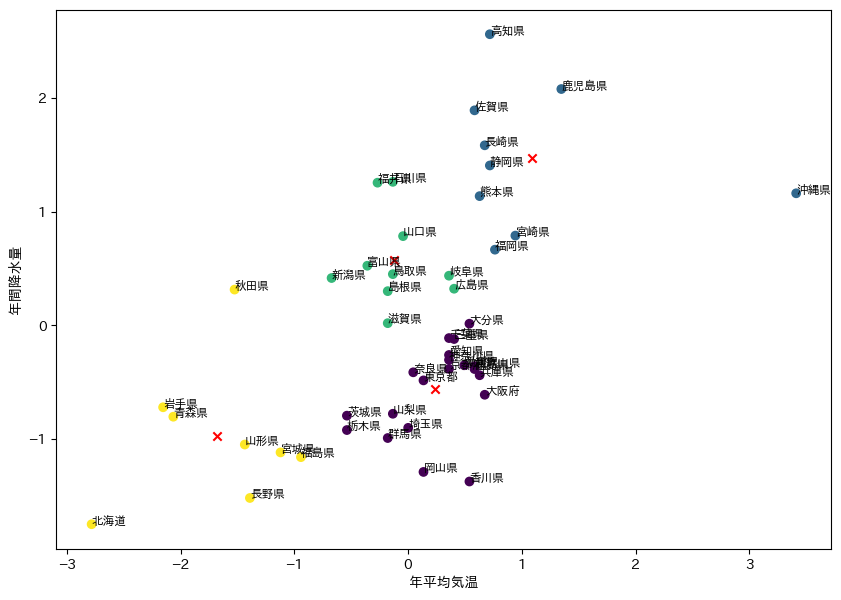

In [ ]:
# クラスタリング結果の可視化
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
labels = df.loc[:, '地域'].values
for i, label in enumerate(labels):
  plt.annotate(label, (X[i, 0], X[i, 1]), fontsize='small')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red')
plt.xlabel('年平均気温')
plt.ylabel('年間降水量')
plt.show()

### scikit-learnによるK-means法の実装
以下では，scikit-learnライブラリのclusterモジュールの[`Kmeans`](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html)クラスを用いて，K-means法によるクラスタリングを行うための手順を示しています．
- `KMeans`クラスのオブジェクトを作成する際，
  - 引数`n_clusters`にクラスタ数を指定します．
  - 引数`random_state`には初期のセントロイドを選択する際の擬似乱数の種（シード）となる値を指定します．
  - 引数`init`に初期のセントロイドを選択する方法を指定できます．
デフォルトでは，K-means++法で行われる初期のセントロイドの選択方法が適用されます．
- `KMeans`クラスのオブジェクトの`fit`メソッドに，データセットとなる[事例の数] $\times$ [特徴の数]のサイズの行列を表す2次元配列を与えて呼び出すことでK-means法によるクラスタリングが行われます．
  - 同オブジェクトの`labels_`属性, `cluster_centers_`属性, `inertia_`属性は先の関数`k_means`の返り値である`clusters`, `centroids`, `cost`にそれぞれ対応しています．

In [ ]:
# scikit-learnのKMeansクラスによるK-means法
from sklearn.cluster import KMeans
model = KMeans(n_init='auto', init='k-means++', n_clusters=4, random_state=0).fit(X)
print(model.labels_)
print(model.cluster_centers_)
print(model.inertia_)

[2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 1 1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 1 1 1 0 1 1 3]
[[ 0.1505458  -0.32540038]
 [ 0.5394823   1.40269638]
 [-1.67633384 -0.97583213]
 [ 3.4116288   1.16280699]]
22.594504831249075


## 参考：混合ガウス分布によるソフトクラスタリング


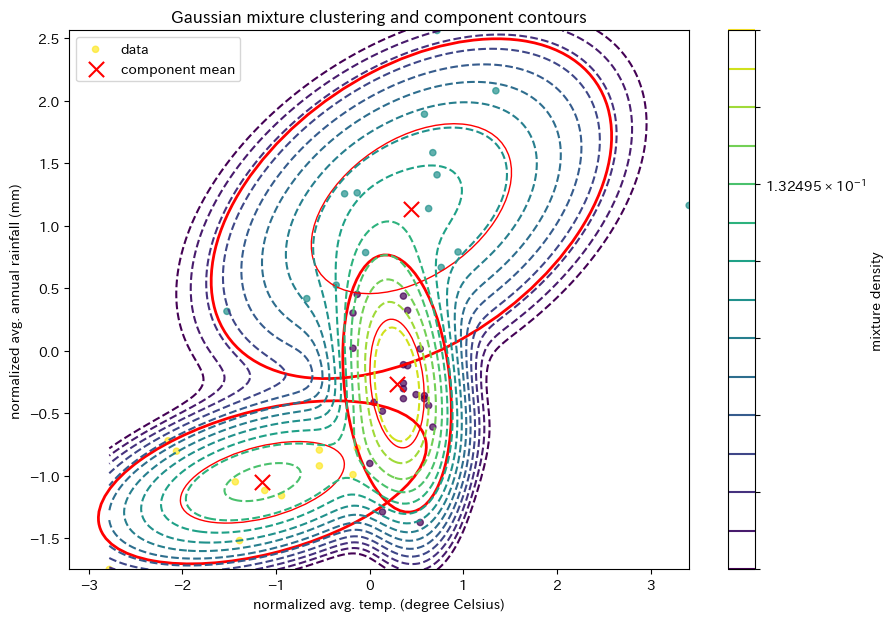

In [ ]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

def plot_gmm_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * n_std * np.sqrt(vals)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    e = Ellipse(xy=mean, width=width, height=height, angle=angle, fill=False, **kwargs)
    ax.add_patch(e)

gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X)
labels = gmm.predict(X) # クラスタラベル
means = gmm.means_
covs = gmm.covariances_
#print(gmm.predict_proba(X)) # 事後確率
#print(gmm.weights_) # 各混合要素の重み

x, y = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 200),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
)
grid = np.column_stack([x.ravel(), y.ravel()])
logprob = gmm.score_samples(grid)
Z = np.exp(logprob).reshape(x.shape)

fig, ax = plt.subplots(figsize=(10, 7))

cs = ax.contour(
    x, y, Z,
    levels=np.logspace(np.log10(Z.max()) - 2, np.log10(Z.max()), 15),
    norm=LogNorm(), linestyles="dashed"
)
fig.colorbar(cs, ax=ax, label="mixture density")

sc = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=20, alpha=0.7, label="data")
ax.scatter(means[:, 0], means[:, 1], c="red", s=120, marker="x", label="component mean")

for m, C in zip(means, covs):
    plot_gmm_ellipse(m, C, ax, n_std=2, lw=2, color="red")
    plot_gmm_ellipse(m, C, ax, n_std=1, lw=1, color="red")

ax.set_xlabel("normalized avg. temp. (degree Celsius)")
ax.set_ylabel("normalized avg. annual rainfall (mm)")
ax.set_title("Gaussian mixture clustering and component contours")
ax.legend()
plt.show()